<a href="https://colab.research.google.com/github/abigailgreenough/learning-pytorch/blob/main/_downloads/070179efc13bd796c5dd4af7bf52d5b9/intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

**Learn the Basics** \|\| [Quickstart](quickstart_tutorial.html) \|\|
[Tensors](tensorqs_tutorial.html) \|\| [Datasets &
DataLoaders](data_tutorial.html) \|\|
[Transforms](transforms_tutorial.html) \|\| [Build
Model](buildmodel_tutorial.html) \|\|
[Autograd](autogradqs_tutorial.html) \|\|
[Optimization](optimization_tutorial.html) \|\| [Save & Load
Model](saveloadrun_tutorial.html)

Learn the Basics
================

Authors: [Suraj Subramanian](https://github.com/subramen), [Seth
Juarez](https://github.com/sethjuarez/), [Cassie
Breviu](https://github.com/cassiebreviu/), [Dmitry
Soshnikov](https://soshnikov.com/), [Ari
Bornstein](https://github.com/aribornstein/)

Most machine learning workflows involve working with data, creating
models, optimizing model parameters, and saving the trained models. This
tutorial introduces you to a complete ML workflow implemented in
PyTorch, with links to learn more about each of these concepts.

We\'ll use the FashionMNIST dataset to train a neural network that
predicts if an input image belongs to one of the following classes:
T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker,
Bag, or Ankle boot.

[This tutorial assumes a basic familiarity with Python and Deep Learning
concepts.]{.title-ref}

Running the Tutorial Code
-------------------------

You can run this tutorial in a couple of ways:

-   **In the cloud**: This is the easiest way to get started! Each
    section has a \"Run in Microsoft Learn\" and \"Run in Google Colab\"
    link at the top, which opens an integrated notebook in Microsoft
    Learn or Google Colab, respectively, with the code in a fully-hosted
    environment.
-   **Locally**: This option requires you to setup PyTorch and
    TorchVision first on your local machine ([installation
    instructions](https://pytorch.org/get-started/locally/)). Download
    the notebook or copy the code into your favorite IDE.

How to Use this Guide
---------------------

If you\'re familiar with other deep learning frameworks, check out the
[0. Quickstart](quickstart_tutorial.html) first to quickly familiarize
yourself with PyTorch\'s API.

If you\'re new to deep learning frameworks, head right into the first
section of our step-by-step guide: [1. Tensors](tensor_tutorial.html).

::: {.toctree maxdepth="2" hidden=""}
quickstart\_tutorial tensorqs\_tutorial data\_tutorial
transforms\_tutorial buildmodel\_tutorial autogradqs\_tutorial
optimization\_tutorial saveloadrun\_tutorial
:::


In [21]:
import torch
import numpy as np

shape = (2, 4) # rows x columns
rand_tensor = torch.rand(shape)

# trying some tensor operations
print("Tensor: \n" + str(rand_tensor))
print("Num elements: " + str(torch.numel(rand_tensor)))
print("Is tensor: " + str(torch.is_tensor(rand_tensor)))

agg = rand_tensor.sum()
print(agg.item())


# in place operations save memory but cause an immediate loss of history,
# hence why their use is discouraged
rand_tensor.add_(2)
print(str(rand_tensor))

# tensor to numpy array
# -> share underlying memory locations, i.e. change in tensor is
#    reflected in numpy array and vice versa
tensor = torch.ones(3)
print(str(tensor))
numpy = tensor.numpy()
print(str(numpy))
tensor.add_(1)
print(str(tensor))
print(str(numpy))

# numpy array to tensor, same logic above applies
numpy2 = np.ones(4)
tensor2 = torch.from_numpy(numpy2)
print(str(tensor2))
print(str(numpy2))

Tensor: 
tensor([[0.1604, 0.8292, 0.3081, 0.5870],
        [0.0923, 0.3719, 0.3358, 0.0925]])
Num elements: 8
Is tensor: True
2.7771074771881104
tensor([[2.1604, 2.8292, 2.3081, 2.5870],
        [2.0923, 2.3719, 2.3358, 2.0925]])
tensor([1., 1., 1.])
[1. 1. 1.]
tensor([2., 2., 2.])
[2. 2. 2.]
tensor([1., 1., 1., 1.], dtype=torch.float64)
[1. 1. 1. 1.]


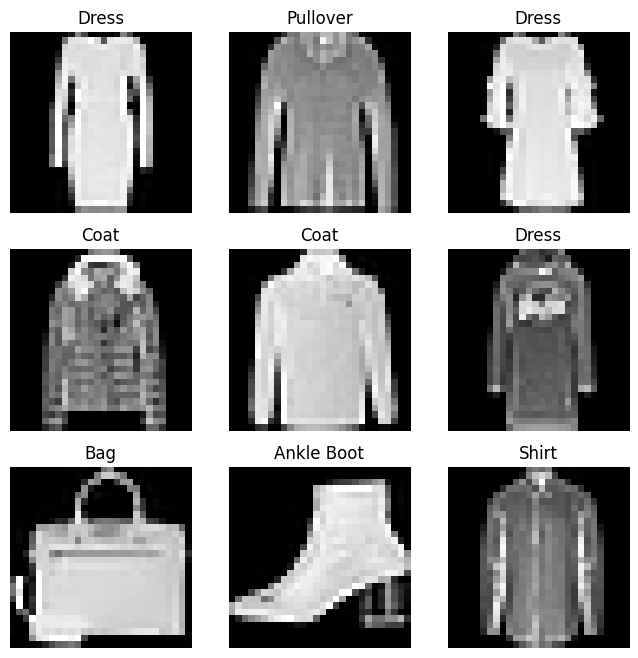

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


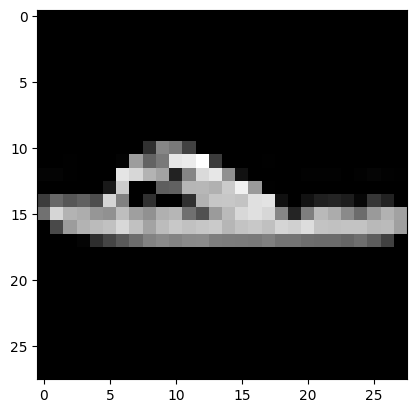

Label: 5


In [22]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt


training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


# custom dataset class
# -> must implement __init__, __len__, and __getitem__
import os
import pandas as pd
from torchvision.io import decode_image

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = decode_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

# preparing data for training with DataLoaders
# -> want to pass samples in minibatches, reshuffling the data to reduce
#    model overfitting
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [23]:
# need to use transforms to manipulate our given data to be suitable
# for training

import torch
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

In [4]:
# building the neural network

import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() # coverts each 2D 28x28 image into a contiguous array of 784 pixel values
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512), # nn.Linear performs linear transformations
            nn.ReLU(), # nn.ReLU creates complex mappings between the model's inputs & outputs, introduces nonlinearity to the model
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

X = torch.rand(1, 28, 28, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

input_image = torch.rand(3,28,28)
print(input_image.size())

flatten = nn.Flatten()
flat_image = flatten(input_image)
print(flat_image.size())

layer1 = nn.Linear(in_features=28*28, out_features=20)
hidden1 = layer1(flat_image)
print(hidden1.size())

print(f"Before ReLU: {hidden1}\n\n")
hidden1 = nn.ReLU()(hidden1)
print(f"After ReLU: {hidden1}")

# creates ordered container of modules
seq_modules = nn.Sequential(
    flatten,
    layer1,
    nn.ReLU(),
    nn.Linear(20, 10)
)
input_image = torch.rand(3,28,28)
logits = seq_modules(input_image)

# Last layer of neural net returns raw values [-infinity, infinity]
# -> nn.Softmax scales to [0,1], representing model's predicated
#    probabilties for each class
softmax = nn.Softmax(dim=1)
pred_probab = softmax(logits)

print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)
Predicted class: tensor([5], device='cuda:0')
torch.Size([3, 28, 28])
torch.Size([3, 784])
torch.Size([3, 20])
Before ReLU: tensor([[ 0.2055, -0.1749,  0.7453, -0.3578, -0.0535, -0.1839, -0.2798, -0.5476,
          0.5472, -0.0316,  0.0510, -0.6357,  0.2522,  0.1691,  0.2272,  0.1756,
         -0.1638, -0.1002, -0.0953,  0.2579],
        [ 0.1847, -0.3447,  0.6066,  0.0681,  0.2118,  0.1202, -0.4076, -0.7664,
          0.5927, -0.4357,  0.1751, -0.5975,  0.3551,  0.2300,  0.1662,  0.1683,
          0.1380, -0.1317, -0.0428,  0.4218],
        [-0.0578,  0.0860,  0.8684, -0.2402,  0.4184, -0.1305, -0.2803, -0.5379,
          0.6829, -0.2441, -0.1106, -0.545

In [7]:
# Automatic Differentiation with torch.autograd

import torch

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

print(f"Gradient function for z = {z.grad_fn}")
print(f"Gradient function for loss = {loss.grad_fn}")

# to optimize weights & biases, need to compute the derivative of the loss
# function with respect to w and b.
loss.backward()
print(w.grad)
print(b.grad)

# ** disable gradient tracking - i.e. when you've trained a model and just want
# to apply some input data, you only want to do forward computations through
# the network. Can "freeze" parameters & speed up computations
z = torch.matmul(x, w)+b
print(z.requires_grad)

with torch.no_grad(): # **
    z = torch.matmul(x, w)+b
print(z.requires_grad)

# detach() achieves the same result
z = torch.matmul(x, w)+b
z_det = z.detach()
print(z_det.requires_grad)

Gradient function for z = <AddBackward0 object at 0x79a879fe6c50>
Gradient function for loss = <BinaryCrossEntropyWithLogitsBackward0 object at 0x79a882959d80>
tensor([[0.0021, 0.0473, 0.2518],
        [0.0021, 0.0473, 0.2518],
        [0.0021, 0.0473, 0.2518],
        [0.0021, 0.0473, 0.2518],
        [0.0021, 0.0473, 0.2518]])
tensor([0.0021, 0.0473, 0.2518])
True
False


In [12]:
# Optimizing Model Parameters

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork()

# Hyperparameters - adjustable parameters that let you control the model
# optimization process

# how much to update the models parameters @ each epoch
# -> smaller values = slow learning speed
# -> larger values = unpredictable behaviour during training
learning_rate = 1e-3

# the number of data samples propagated through the network before the
# parameters are updated
batch_size = 64

# number of times to iterate over the dataset
#   (def epoch: one iteration of the optimization loop)
# Each epoch has 2 main parts:
# 1. Train loop: iterate over training dataset and try to converge to
#     optimal paramaters
# 2. Validation/Test loop: iterate over the test dataset to check if model
#     performance is improving
epochs = 5

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")


Epoch 1
-------------------------------
loss: 2.318349  [   64/60000]
loss: 2.300079  [ 6464/60000]
loss: 2.285619  [12864/60000]
loss: 2.269630  [19264/60000]
loss: 2.256372  [25664/60000]
loss: 2.237338  [32064/60000]
loss: 2.240811  [38464/60000]
loss: 2.212530  [44864/60000]
loss: 2.207826  [51264/60000]
loss: 2.173938  [57664/60000]
Test Error: 
 Accuracy: 42.2%, Avg loss: 2.170748 

Epoch 2
-------------------------------
loss: 2.189746  [   64/60000]
loss: 2.177900  [ 6464/60000]
loss: 2.125684  [12864/60000]
loss: 2.132094  [19264/60000]
loss: 2.088257  [25664/60000]
loss: 2.039070  [32064/60000]
loss: 2.064540  [38464/60000]
loss: 1.993462  [44864/60000]
loss: 1.995914  [51264/60000]
loss: 1.922502  [57664/60000]
Test Error: 
 Accuracy: 53.4%, Avg loss: 1.919706 

Epoch 3
-------------------------------
loss: 1.961888  [   64/60000]
loss: 1.933974  [ 6464/60000]
loss: 1.817768  [12864/60000]
loss: 1.846693  [19264/60000]
loss: 1.741249  [25664/60000]
loss: 1.694797  [32064/600

In [15]:
# Save and load the model

import torch
import torchvision.models as models

model = models.vgg16(weights='IMAGENET1K_V1')
torch.save(model.state_dict(), 'model_weights.pth')

model = models.vgg16() # we do not specify ``weights``, i.e. create untrained model
model.load_state_dict(torch.load('model_weights.pth', weights_only=True))
model.eval()

torch.save(model, 'model.pth')
model = torch.load('model.pth', weights_only=False),